# Notes in chapter 8
1. At a minimum, the arguments we provide to nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output features, and the size of the kernel.
2. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a B × C × H × W shaped tensor as input.
3. Training a model involves two critical steps: optimization, when we need the loss to
decrease on the training set; and eneralization, when the model has to work not only on the training set but also on data it has not seen before, like the validation set. The mathematical tools aimed at easing these two steps are sometimes subsumed under
the label regularization.

## 8.1 The case for convolutions

## 8.2 Convolutions in action

In [1]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [2]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [3]:
from torchvision import datasets

data_path = 'data/ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=False)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

from torchvision import transforms

transformd_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)
transformd_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4943, 0.4852, 0.4506), (0.2467, 0.2429, 0.2616))
    ]))

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformd_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformd_cifar10_val if label in [0, 2]]

In [4]:

len(cifar2), len(cifar2_val)

(10000, 2000)

In [5]:
img, _ = cifar2[0]
conv = nn.Conv2d(3, 16, kernel_size=3)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

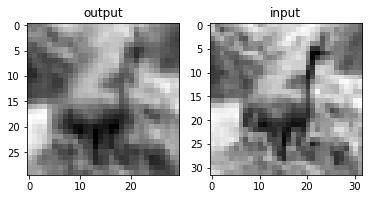

In [6]:
from matplotlib import pyplot as plt 

plt.subplot(1, 2, 1)
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title("output")

plt.subplot(1, 2, 2)
plt.imshow(img[0], cmap='gray')
plt.title("input")
plt.show()

In [7]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [8]:
import torch

with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9)

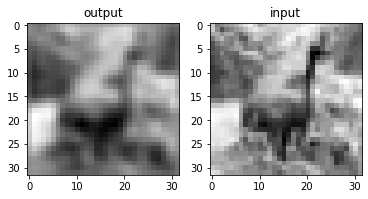

In [9]:
output = conv(img.unsqueeze(0))

plt.subplot(1, 2, 1)
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.title("output")

plt.subplot(1, 2, 2)
plt.imshow(img[0], cmap='gray')
plt.title("input")
plt.show()

In [10]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [11]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # missing something important
    nn.Linear(8*8*8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [17]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel__list), numel__list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

## 8.3 Subclassing nn.Module

In [13]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(x)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
model = Net()

numel__list = [p.numel() for p in model.parameters()]
sum(numel__list), numel__list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [23]:
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [24]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.1336, -0.0253]], grad_fn=<AddmmBackward>)

## 8.4 Traning our convnet

In [25]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Trainning loss {}'.format(datetime.datetime.now(), epoch, loss / len(train_loader)))

In [ ]:
import torch.utils.data
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name, correct / total))

In [ ]:
torch.save(model.state_dict(), "data/ch8/ch8.pt")

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name, correct / total))

In [ ]:
validate(model, train_loader, val_loader)

In [ ]:
import torch

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Trainning loss {}'.format(datetime.datetime.now(), epoch, loss / len(train_loader)))

In [ ]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader
)

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = imgs.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        
        print("Accuracy {}: {:.2f}".format(name, correct / total))

In [ ]:
validate(model, train_loader, val_loader)

## 8.5 Model design

In [ ]:
# L2 regularization
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p on model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))